# Linear Regression

In [1]:
import math
import random
import numpy as np
import pandas as pd
import scipy
import sympy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style= 'whitegrid')

Regression: a function fit to observed data to make predictions about new data <br>
Linear regression: straight line regression

Statistics approach: prediction intervals, correlation <br>
Machine learning approach: validation via train-test split

Statisticians call it statistical learning <br>
ML practitioners call it machine learning

Supervised learning is often regression <br>
Unsupervised learning is often clustering and anomaly detection <br>
Reinforcement learning often combines both types to generate synthetic data

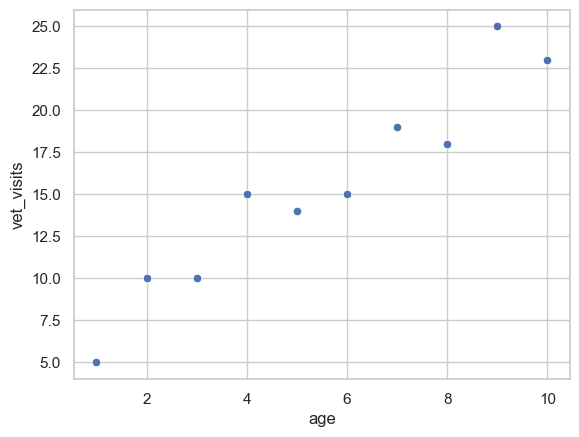

In [3]:
# prepare data
ages = [i for i in range(1, 11)]
vet_visits = [5, 10, 10, 15, 14, 15, 19, 18, 25, 23]

# useable format (DataFrame)
vet_visits_by_age = pd.DataFrame(
    data=np.array([ages, vet_visits]).transpose(),
    columns=['age', 'vet_visits'])

# plot data
sns.scatterplot(
    data= vet_visits_by_age,
    x= 'age',
    y= 'vet_visits'
);

Do not make predictions outside the range of data available! 

m = [1.93939394]
b = [4.73333333]


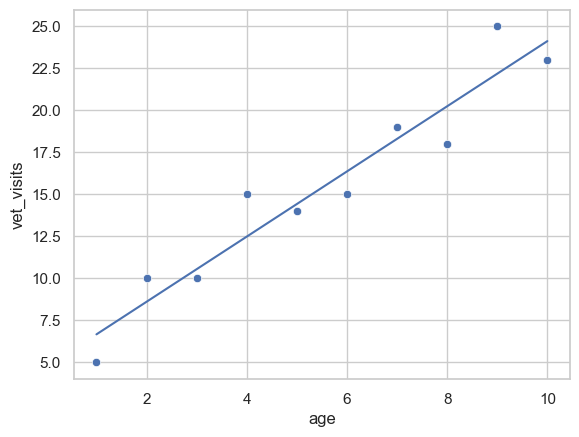

In [4]:
# extract input variables
X = vet_visits_by_age.values[:, :-1]
# extract output variables
y = vet_visits_by_age.values[:, -1]

# fit a line to the points
fit = LinearRegression().fit(X, y)

# get slope and intercept
m = fit.coef_.flatten()
b = fit.intercept_.flatten()
print(f'm = {m}')
print(f'b = {b}')

# plot in chart
sns.scatterplot(
    data= vet_visits_by_age,
    x= 'age',
    y= 'vet_visits'
)
plt.plot(X, m*X+b)
plt.show();

Residual: numeric difference between regression line and observed data points <br>
residuals are also called errors

In [5]:
# print residual for each point in dataset
points = vet_visits_by_age.itertuples()
for p in points:
    y_actual = p.vet_visits
    y_predict = m*p.age + b
    residual = y_actual - y_predict
    print(residual)

[-1.67272727]
[1.38787879]
[-0.55151515]
[2.50909091]
[-0.43030303]
[-1.36969697]
[0.69090909]
[-2.24848485]
[2.81212121]
[-1.12727273]


best approach to minimize residuals is to use sum of squares - square and sum all residuals <br>
use squares instead of absolute values because squares work better with derivatives

$ \Sigma_{squares} = \displaystyle\sum_{i=0}^{n} ((mx_i+b) - y_i)^2 $

In [6]:
# find sum of squares for fit regression line
points = vet_visits_by_age.itertuples()
sum_of_squares = 0.0
for p in points:
    y_actual = p.vet_visits
    y_predict = m*p.age + b
    residual_squared = (y_predict - y_actual)**2
    sum_of_squares += residual_squared

print(f'Sum of squares = {sum_of_squares}')

Sum of squares = [28.0969697]


The heart of machine learning:
1. Provide some data
2. Provide an objective function (often minimizing error, loss, etc.)
3. Let the model find the correct coefficients to complete the objective

Closed form equation: a formula to fit a model / regression

Closed form equations often exist for only very simple models, such as a linear regression with one input and one output.

$ m = \frac{n\Sigma xy - \Sigma x \Sigma y}{n \Sigma x^2 - (\Sigma x)^2} $

$ b = {\Sigma y \over n} - m{\Sigma x \over n} $

In [7]:
# get data points
points = list(vet_visits_by_age.itertuples())
n = len(points)

# closed form equation calculation for slope
m = (
    (n*sum(p.age*p.vet_visits for p in points) -
        sum(p.age for p in points) *
        sum(p.vet_visits for p in points))
    /
    (n*sum(p.age**2 for p in points) -
     sum(p.age for p in points)**2)
)

# closed form equation calculation for intercept
b = (
    (sum(p.vet_visits for p in points) / n) - \
    m * sum(p.age for p in points) / n
)

print(m, b)

1.9393939393939394 4.7333333333333325


coefficients and intercepts $m$ and $b$ are often represented as $\beta_1$ and $\beta_0$

coefficients (and intercepts, though they are often just referred to as coefficients) can also be found using matrix techniques

$\vec{b} = (X^{T} \cdot X)^{-1} \cdot X^{T} \cdot y$, where

$X^T$ is the transposed $X$ matrix

In [8]:
# get input variables
X = vet_visits_by_age.values[:, :-1].flatten()

# placeholder column of 1s to generate intercept
X_1 = np.vstack([X, np.ones(len(X))]).T

# get output variable
y = vet_visits_by_age.values[:, -1]

# calculate coefficients
b = np.linalg.inv(X_1.transpose() @ X_1) @ (X_1.transpose() @ y)
print(b)

# predict y values for inputs
y_predict = X_1.dot(b)
print(y_predict)

[1.93939394 4.73333333]
[ 6.67272727  8.61212121 10.55151515 12.49090909 14.43030303 16.36969697
 18.30909091 20.24848485 22.18787879 24.12727273]


QR decomposition can also be used to find coefficients

$ X = Q \cdot R $

$ \vec{b} = R^{-1} \cdot Q^T \cdot y $

In [9]:
# coefficients for slope and intercept using QR decomposition
Q, R = np.linalg.qr(X_1)
b = np.linalg.inv(R).dot(Q.transpose()).dot(y)
print(b)

[1.93939394 4.73333333]


QR decomposition is the method used by many scientific computer libraries for linear regression because it is *numerically stable*

Numerical stability: how well an algorithm keeps errors minimized (rather than amplifying errors in approximations)

Gradient descent: using derivatives and integrations to minmax a set of parameters against an objective <br>
gradient descent uses partial derivatives to see the slope for every parameter, and adjust the parameters toward the steepest slope downward by the *learning rate*

Learning rate: the length of the step (a fraction of the slope) to take in each iteration of gradient descent <br>
choosing the correct learning rate is a tradeoff of speed (# iterations) and accuracy (smallest distance from minimum)

In [10]:
# finding lowest point x (minimizing slope) for (x-3)^2 + 4
def f(x):
    return (x - 3)**2 + 4

def dx_f(x):
    return 2*(x - 3)

# learning rate
L = 0.001

iterations = 100_000

# start at random x
x = random.randint(-15, 15)

for i in range(iterations):
    # get slope
    d_x = dx_f(x)
    # update x (learning rate * slope)
    x -= d_x * L

print(x, f(x))

3.000000000000111 4.0


Objective function (sum of squares) for linear regression with 1 input variable, and partial derivatives:

$ e(x) = \displaystyle\sum_{i=0}^{n} ((mx_i+b) - y_i)^2 $

$ {d \over dm}e(x) = \displaystyle\sum_{i=0}^{n} (2((mx_i+b) - y_i)x_i) $

$ {d \over db}e(x) = \displaystyle\sum_{i=0}^{n} (2((mx_i+b) - y_i)) $

In [11]:
# gradient descent linear regression for dog data
points = list(vet_visits_by_age.itertuples())
# set parameter starts
m = 0.0
b = 0.0

# set model hyperparameters
L = 0.001
iterations = 100_000
n = float(len(points))

# perform gradient descent
for i in range(iterations):
    # partial derivatives
    D_m = sum(2*p.age*((m*p.age+b)-p.vet_visits) for p in points)
    D_b = sum(2*((m*p.age+b)-p.vet_visits) for p in points)

    # update coefficients
    m -= D_m * L
    b -= D_b * L

print(f'y = {m}x + {b}')

y = 1.9393939393939548x + 4.733333333333227


In [12]:
# gradient descent linear regression using SymPy

# define coefficients, symbols, and variables
m, b, i, n = sympy.symbols('m b i n')
x, y = sympy.symbols('x y', cls=sympy.Function)

# objective function
sum_of_squares = sympy.Sum((m*x(i) + b - y(i)) ** 2, (i, 0, n))

# compute derivatives and substitute actual values
d_m = sympy.diff(sum_of_squares, m) \
    .subs(n, len(points)-1).doit() \
    .replace(x, lambda i: points[i].age) \
    .replace(y, lambda i: points[i].vet_visits)
d_b = sympy.diff(sum_of_squares, b) \
    .subs(n, len(points)-1).doit() \
    .replace(x, lambda i: points[i].age) \
    .replace(y, lambda i: points[i].vet_visits)
# use lambdify for faster computing
d_m = sympy.lambdify([m, b], d_m)
d_b = sympy.lambdify([m, b], d_b)

# set parameter starts
m = 0.0
b = 0.0

# set model hyperparameters
L = 0.001
iterations = 100_000

# perform gradient descent
for i in range(iterations):
    m -= d_m(m, b) * L
    b -= d_b(m, b) * L

print(f'y = {m}x + {b}')

y = 1.939393939393954x + 4.733333333333231


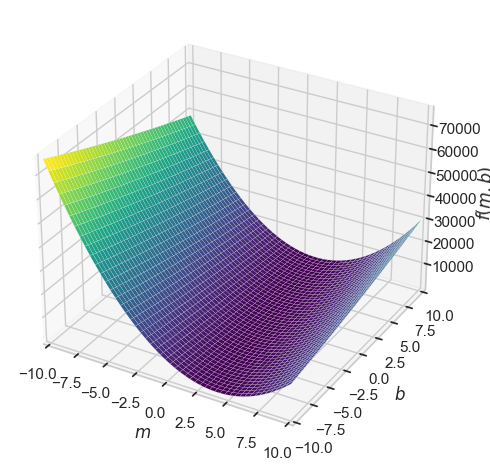

In [13]:
# plot loss landscape

# define coefficients, symbols, and variables
m, b, i, n = sympy.symbols('m b i n')
x, y = sympy.symbols('x y', cls=sympy.Function)

# objective function
sum_of_squares = sympy.Sum((m*x(i) + b - y(i)) ** 2, (i, 0, n)) \
    .subs(n, len(points)-1).doit() \
    .replace(x, lambda i: points[i].age) \
    .replace(y, lambda i: points[i].vet_visits)

sympy.plotting.plot3d(sum_of_squares);

Finding a function which minimizes the loss perfectly is counterproductive - such a model would have very high *variance* between predictions; the model would suffer from *overfitting*.

Overfitting: The model fits the presented (training) data too well, so it poorly predicts new (testing) data <br>
overfitting increases variance

Prioritizing a certain kind of function that does not fit the data well enough would cause the model to be inflexible with a lot of *bias*; the model would suffer from *underfitting*.

Underfitting: model prioritizes a certain method (e.g. maintaining a straight line) and so does not fit the shape of the data <br>
underfitting increases bias

The ideal model strikes the perfect balance between variance and bias, such that the model best captures the *shape* of the data, able to make predictions with a consistent degree of error.

Some popular variants of linear regression:

Ridge regression: adds a bias to a linear regression, causing it to fit less to the data <br>
useful for models that are susceptible to overfitting

Lasso regression: marginalizes noisy variables <br>
useful for automatically removing variables that might be irrelevant


Stochastic gradient descent: training on only one data point per iteration <br>
this is a good option for minimizing computational complexity, and prevents overfitting by only exposing portions of the data to the model in each iteration, rather than batch (normal) gradient descent, in which the model is trained on the entire dataset for every iteration

Mini-batch gradient descent is a strong version of SGD, where a small batch (10 or 100 data points, etc) are trained on each iteration.

In [14]:
# SGD on dogs dataset

# input and output variables
X = vet_visits_by_age.values[:, :-1]
y = vet_visits_by_age.values[:, -1]

n = vet_visits_by_age.shape[0]

# set parameters
m = 0.0
b = 0.0

# set model hyperparameters
sample_size = 1
L = 0.001
epochs = 100_000

# SGD
for i in range(epochs):
    # get sample
    idx = np.random.choice(n, sample_size, replace=False)
    X_sample = X[idx]
    y_sample = y[idx]

    # predict value for sample
    y_pred = m * X_sample + b

    # derivatives of loss function
    D_m = (-2 / sample_size) * sum(X_sample * (y_sample - y_pred))
    D_b = (-2 / sample_size) * sum(y_sample - y_pred)

    # update parameters
    m -= D_m * L
    b -= D_b * L

    if i % 10_000 == 0:
        print(i, m, b)
    
print(f'y = {m}x + {b}')


0 [0.12] [0.03]
10000 [1.99419346] [4.68441119]
20000 [1.92283862] [4.76372742]
30000 [1.94028219] [4.6961752]
40000 [1.93354288] [4.76783164]
50000 [1.94255639] [4.65029585]
60000 [1.92675002] [4.73554621]
70000 [1.96170059] [4.76277723]
80000 [2.01900642] [4.73878735]
90000 [2.11269565] [4.68764364]
y = [1.94304003]x + [4.76785424]


Randomness is inevitable in machine learning, optimization, and stochastic algorithms.

**ML/AI IS IMPRECISE, NONDETERMINISTIC AND APPROXIMATE IN NATURE**

Correlation coefficient: Measures the strength of a relationship between two variables <br>
also called the Pearson correlation <br>
Range is [-1, 1] where 0 means no correlation and -1 or 1 means perfect negative or positive correlation, respectively

In [15]:
# correlation coefficient for dog data
correlations = vet_visits_by_age.corr(method='pearson')
display(correlations)

,age,vet_visits
age,1.000000,0.957586
vet_visits,0.957586,1.000000


Correlation coefficient:

$ r = \frac{n\Sigma xy - (\Sigma x)(\Sigma y)}{\sqrt{n\Sigma x^2 - (\Sigma x^2)}\sqrt{n\Sigma y^2 - (\Sigma y^2)}} = \frac{\Sigma (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\Sigma (x_i - \bar{x})^2 \Sigma (y_i - \bar{y})^2 }} $

In [16]:
# manual calculation of correlation coefficient
points = list(vet_visits_by_age.itertuples())
n = len(points)

numerator = n * sum(p.age * p.vet_visits for p in points) - \
    sum(p.age for p in points) * sum(p.vet_visits for p in points)

denominator = math.sqrt(n*sum(p.age**2 for p in points) - sum(p.age for p in points)**2) * \
    math.sqrt(n*sum(p.vet_visits**2 for p in points) - sum(p.vet_visits for p in points)**2)

corr = numerator / denominator

print(corr)

0.9575860952087218


Check statistical significance of correlations! Correlation might be due to chance!

$ H_0: \rho = 0 $ <br>
$ H_1: \rho \neq 0 $, where

$\rho$ is the population correlation coefficient

For a dataset with 10 data points, use a T-distribution with 9 ($n-1$, 10-1=9) degrees of freedom

Using a T-distribution rather than a normal distribution for hypothesis testing in linear regression is a good practice, even with sample sizes > 30.

In [17]:
# get critical t value
n = 10
lower_cv = scipy.stats.t(n-1).ppf(0.025)
upper_cv = scipy.stats.t(n-1).ppf(0.975)

print(lower_cv, upper_cv)

-2.262157162740992 2.2621571627409915


The test value t needs to be calculated and compared to the critical values

$ t = \frac{r}{\sqrt{\frac{1-r^2}{n-2}}} $, where

$t$ is the test value t, <br>
$r$ is the sample correlation coefficient, and <br>
$n$ is the sample size

In [18]:
# statistical significance of correlation
r = corr
test_value = r / math.sqrt((1-r**2) / (n-2))

if test_value > 0:
    p_value = 1.0 - scipy.stats.t(n-1).cdf(test_value)
else:
    p_value = scipy.stats.t(n-1).cdf(test_value)

print(r)
print(lower_cv, upper_cv)
print(test_value)
print(p_value)

0.9575860952087218
-2.262157162740992 2.2621571627409915
9.399575927136752
2.988163549710876e-06


having more data (that consistently resembles a line) increases the p-value of the correlation. less data means that the data has a greater possibility of having a correlation due to chance

Coefficient of determination: $r^2$, measures how much two variables interact with each other <br>
or, how much variation in one variable is explained by the variation in another variable.

In [19]:
# coefficient of determination
coeff_determination = vet_visits_by_age.corr(method='pearson')**2
display(coeff_determination)

,age,vet_visits
age,1.000000,0.916971
vet_visits,0.916971,1.000000


**CORRELATION IS NOT CAUSATION**

For two variables X and Y, correlation can indicate:

1. X causes Y
2. Y causes X
3. Z causes X and Y
4. Etc.

Sum of squared error: measures overall error in regression

$ SSE = \Sigma(y - \hat{y})^2 $

Squared values are hard to interpret, so to convert error back to its original units using a square root to find the standard error of the estimate

$S_e = \sqrt{\frac{\Sigma(y - \hat{y})^2}{n-2}} $

Standard error of the estimate is the standard deviation of a linear regression

In [20]:
# calculate standard error of estimate
points = list(vet_visits_by_age.itertuples())
n = len(points)

# regression coefficients
m = 1.939
b = 4.733

S_e = math.sqrt((sum((p.vet_visits - (m*p.age +b))**2 for p in points))/(n-2))

print(S_e)

1.87406793500129


Prediction interval: confidence interval around each y prediction

$ PI = \hat{y} \pm E $

$ E = t_c * S_e * \sqrt{1 + {1 \over n} + \frac{n(x_0 + \bar{x})^2}{n(\Sigma x^2) - (\Sigma x)^2}} $, where

$ PI $ is the prediction interval, <br>
$ E $ is the margin of error, <br>
$ t_c $ is the critical value for the chosen confidence (alpha), and <br>
$ x_0 $ is the independent variable to predict.

In [21]:
# prediction interval for dog age = 8.5 yrs
x_0 = 8.5
x_mean = sum(p.age for p in points) / n

t_value = scipy.stats.t(n-2).ppf(0.975)

standard_error = math.sqrt((sum((p.vet_visits - (m*p.age +b))**2 for p in points))/(n-2))

margin_of_error = t_value * standard_error * \
    math.sqrt(1 + (1/n) + (n * (x_0 - x_mean)**2) / \
        (n * sum(p.age**2 for p in points) - \
        sum(p.age for p in points)**2)
        )

predicted_y = m*x_0 + b

prediction_interval_lower = predicted_y - margin_of_error
prediction_interval_upper = predicted_y + margin_of_error

print(prediction_interval_lower, prediction_interval_upper)

16.462516875955465 25.966483124044537


Statistical regression: high explainability and precision, but low scalability and narrow predictions <br>
Machine learning: high scalability and broad predictions, but low explainability and precision

Confidence intervals and p-values are open problems in higher-dimensional data

p-values require assumptions on data not met by ML data (no multicollinearity, enough data compared to dimensionality, etc)

train test split: portioning of available data so most data is used to train the model, and some data remains to measure the model's performance on unseen data (validate performance and mitigate variance and bias) <br>
typically 1/3 of the data is set aside for testing and the rest is for training, though splits can differ based on volume of data (75/25, 80/20, 90/10, etc).

$ r^2 $ is calculated differently for testing a fitted model, since we are comparing testing data to a regression line built from training data

$ r^2 = 1 - \frac{\Sigma(y_i - \hat{y_i})^2}{\Sigma(y_i - \bar{y})^2} $, where

$ y_i $ is the actual y value, <br>
$ \hat{y_i} $ is the predicted y value, and <br>
$ \bar{y} $ is the mean y value for all (testing) data points

Cross validation: alternating the testing set across portions or *folds* of the data, training and testing distinct models on each train-test split, then finding the average score across all versions of the model (e.g. use 1/3 of data in each testing set, train and test on each fold, then average test scores for all folds)

k-fold validation: cross validation using $k$ folds

In [22]:
# score linear regression using cross validation

# input and output variables
X = vet_visits_by_age.values[:, :-1]
y = vet_visits_by_age.values[:, -1]

# generate folds for cross validation
kfold = KFold(n_splits=3, random_state=42, shuffle=True)

# fit model and score
model = LinearRegression()
results = cross_val_score(model, X, y, cv=kfold)
print(f'MSE: mean = {results.mean()}, stdev = {results.std()}')

MSE: mean = 0.6388518016877424, stdev = 0.24783594793825303


leave one out cross validation (LOOCV): alternates each individual data point as the testing set in cross validation <br>
use LOOCV when dataset is very small

random-fold validation: repeatedly shuffle and train test split data (up to infinite) number of times and aggregate testing results.
- get mean and stdev for testing results
- see how consistently testing sets perform (helps mitigate p-hacking)
- computationally expensive

train test splits are a good measure of performance on data too voluminous to statistically analyze

train validation test split: splitting data into training, validation, and testing sets <br>
validation and training sets are useful for comparing different models or configurations, and testing set is the true test of the final model on unseen data

metrics and methods for linear regression can be used on multiple regression, though more variables means less explainability, and data becomes sparser

black-box modeling (most machine learning) can yield strong results but cannot be explained

**STATISTICAL CONCERNS DO NOT GO AWAY**

analyze relationships between variables to see how they interact <br>
this helps to build a strong, explainable ML model

statistical (scalpel) vs ML (chainsaw) approach is situational. Judge which is best for the situation at hand

In [23]:
# exercises dataset
df = pd.read_csv('https://bit.ly/3C8JzrM')
print(df.shape)
display(df.head())

(99, 2)


,x,y
0,1,-13.115843
1,2,25.806547
2,3,-5.017285
3,4,20.256415
4,5,4.075003


In [24]:
# exercise 1
X = df.values[:, :-1]
y = df.values[:, -1]
fit = LinearRegression().fit(X, y)
m = fit.coef_.flatten()[0]
b = fit.intercept_.flatten()[0]

print(f'y = {m}x + {b}')

y = 1.759193148105248x + 4.69359654825405


In [25]:
# exercise 2

corr = df.corr()

r = corr.iloc[0, 1]
test_value = r / math.sqrt((1-r**2) / (n-2))

if test_value > 0:
    p_value = 1.0 - scipy.stats.t(n-1).cdf(test_value)
else:
    p_value = scipy.stats.t(n-1).cdf(test_value)

print(f'correlation coefficient: {r}')
print(f'critical t values at 95%: ({lower_cv}, {upper_cv})')
print(f'test value: {test_value}')
print(f'p-value: {p_value}')

correlation coefficient: 0.924210062867716
critical t values at 95%: (-2.262157162740992, 2.2621571627409915)
test value: 6.845161076596901
p-value: 3.7570062628833334e-05


In [26]:
# exercise 3

x_0 = 50
n = df.shape[0]
points = list(df.itertuples())
x_mean = sum(p.x for p in points) / n

t_value = scipy.stats.t(n-2).ppf(0.975)

standard_error = math.sqrt((sum((p.y - (m*p.x +b))**2 for p in points))/(n-2))

margin_of_error = t_value * standard_error * \
    math.sqrt(1 + (1/n) + (n * (x_0 - x_mean)**2) / \
        (n * sum(p.x**2 for p in points) - \
        sum(p.x for p in points)**2)
        )

predicted_y = m*x_0 + b

prediction_interval_lower = predicted_y - margin_of_error
prediction_interval_upper = predicted_y + margin_of_error

print(prediction_interval_lower, prediction_interval_upper)

50.792086404572395 134.51442150246052


In [27]:
# exercise 4
kfold = KFold(n_splits= 5, shuffle= True)

model = LinearRegression()
results = cross_val_score(model, X, y, cv= kfold)
print(f'MLE: mean = {results.mean()}, stdev = {results.std()}')

MLE: mean = 0.8320801015831047, stdev = 0.044748036412307964
